# FastAI Experiments

In [86]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle

## Download dataset if not done already

In [1]:
! curl -O https://iscxdownloads.cs.unb.ca/iscxdownloads/ISCX-Tor-NonTor-2017/TorCSV.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.5M  100 17.5M    0     0  3431k      0  0:00:05  0:00:05 --:--:-- 3637k


## check for TorCSV.zip file

In [2]:
! ls

FastAI-Experiments.ipynb README.md
LICENSE                  TorCSV.zip


## unzip TorCSV.zip file

In [3]:
! unzip TorCSV.zip

Archive:  TorCSV.zip
   creating: CSV/
   creating: CSV/Scenario-A/
  inflating: CSV/Scenario-A/SelectedFeatures-10s-TOR-NonTOR.csv  
  inflating: CSV/Scenario-A/SelectedFeatures-15s-TOR-NonTOR.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-15.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-15.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTOR-15.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTOR-85.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTOR.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-15.arff  
  inflating: CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff  
  inflating: CSV/Scenario-A

In [7]:
! ls CSV
# you'll see CSV root folder two subfolders Scenario-A and Scenario-B inside it

Scenario-A Scenario-B


## Clean Data
- drop columns 'Source IP' and 'Destination IP'
    - these features do not provide packet properties that aid in traffic classification
- drop rows with values with NaN and Infinity
    - can't properly represent these values

In [75]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # Note: there's a leading space for each column name except for the first one
        # let's strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        df.drop(columns=['Source IP', 'Destination IP'], inplace=True)
        # drop missing values/NaN etc.
        df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]=='NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        # convert  Flow Bytes/s object & Flow Packets/s object into float type
        df['Flow Bytes/s'] = df['Flow Bytes/s'].astype('float64')
        df['Flow Packets/s'] = df['Flow Packets/s'].astype('float64')
        print(df.tail())
        df.to_pickle(pickleDump)
    
    return df

## Experimenting with Scenario-A Dataset

In [145]:
dataPath = 'CSV/Scenario-A'
csvFile = os.path.join(dataPath, 'merged_5s.csv')

In [146]:
df = loadData(csvFile)

In [147]:
# check datatypes of each features
df.dtypes

Source Port           int64
Destination Port      int64
Protocol              int64
Flow Duration         int64
Flow Bytes/s        float64
Flow Packets/s      float64
Flow IAT Mean       float64
Flow IAT Std        float64
Flow IAT Max          int64
Flow IAT Min          int64
Fwd IAT Mean        float64
Fwd IAT Std         float64
Fwd IAT Max           int64
Fwd IAT Min           int64
Bwd IAT Mean        float64
Bwd IAT Std         float64
Bwd IAT Max           int64
Bwd IAT Min           int64
Active Mean           int64
Active Std            int64
Active Max            int64
Active Min            int64
Idle Mean             int64
Idle Std              int64
Idle Max              int64
Idle Min              int64
label                object
dtype: object

In [148]:
df.shape

(84187, 27)

In [149]:
# total Tor samples
print('total TOR:', len(df[df['label'] == 'TOR'].index))
print('total nonTOR: ', len(df[df['label'] == 'nonTOR'].index))

total TOR: 14507
total nonTOR:  69680


In [150]:
dep_var = 'label'
cat_names = ['Source Port', 'Destination Port', 'Protocol']
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [151]:
cont_names

['Flow IAT Max',
 'Active Max',
 'Flow IAT Std',
 'Flow Packets/s',
 'Flow Bytes/s',
 'Active Std',
 'Flow IAT Min',
 'Idle Min',
 'Idle Max',
 'Fwd IAT Mean',
 'Idle Std',
 'Bwd IAT Std',
 'Idle Mean',
 'Active Mean',
 'Fwd IAT Min',
 'Flow IAT Mean',
 'Flow Duration',
 'Fwd IAT Std',
 'Bwd IAT Max',
 'Fwd IAT Max',
 'Bwd IAT Mean',
 'Bwd IAT Min',
 'Active Min']

In [154]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,0.011850,0.009388,0.998515,01:16
1,0.005683,0.006707,0.998396,01:30
2,0.001925,0.001732,0.999406,01:48
3,0.002880,0.019688,0.999347,01:54
4,0.003746,0.002355,0.999584,01:52
5,0.000140,0.000836,0.999881,01:55
6,0.000261,0.004255,0.999822,01:45
7,0.000069,0.010362,0.999703,01:34
8,0.000659,0.022007,0.999644,01:29
9,0.000436,0.019929,0.999644,01:27


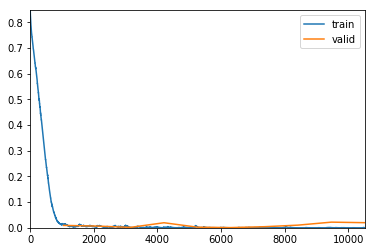

In [155]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    model.save('{}.model'.format(os.path.basename(csvFile)))

In [156]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.01992872543632984: accuracy: 99.96%


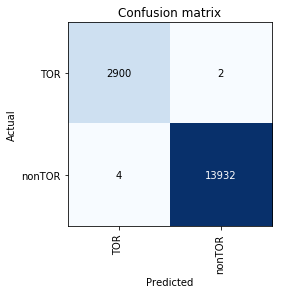

In [157]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

## Experiment with Scenario-B Dataset

In [110]:
dataPath = 'CSV/Scenario-B'
csvFile = os.path.join(dataPath, 'merged_5s.csv')
df = loadData(csvFile)

deleting 1 rows with Infinity in column Flow Bytes/s
       Source Port  Destination Port  Protocol  Flow Duration   Flow Bytes/s  \
14503          110             47257         6        3648143    3572.228391   
14504          110             47257         6         396893    4104.380778   
14505          110             47257         6           1327  818387.339864   
14506          110             47257         6        4975151    3595.870758   
14507          110             47257         6           2172  500000.000000   

       Flow Packets/s  Flow IAT Mean   Flow IAT Std  Flow IAT Max  \
14503       11.786819   86860.547619  124077.405598        486240   
14504       15.117425   79378.600000  176971.627751        395955   
14505     2260.738508     663.500000     586.191522          1078   
14506       10.451944   97551.980392  395666.184256       2803964   
14507     1841.620626     724.000000     990.851654          1861   

       Flow IAT Min  ...  Bwd IAT Min  Active Mean 

/Users/rbasnet/miniconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [111]:
df.dtypes

Source Port           int64
Destination Port      int64
Protocol              int64
Flow Duration         int64
Flow Bytes/s        float64
Flow Packets/s      float64
Flow IAT Mean       float64
Flow IAT Std        float64
Flow IAT Max          int64
Flow IAT Min          int64
Fwd IAT Mean        float64
Fwd IAT Std         float64
Fwd IAT Max           int64
Fwd IAT Min           int64
Bwd IAT Mean        float64
Bwd IAT Std         float64
Bwd IAT Max           int64
Bwd IAT Min           int64
Active Mean           int64
Active Std            int64
Active Max            int64
Active Min            int64
Idle Mean             int64
Idle Std              int64
Idle Max              int64
Idle Min              int64
label                object
dtype: object

In [117]:
# see all the labels
labels = set(df['label'])
print('all the labels:', labels)
# data districution for each label
for label in labels:
    print('total {} = {}'.format(label, len(df[df['label'] == label].index)))


all the labels: {'FILE-TRANSFER', 'BROWSING', 'VIDEO', 'AUDIO', 'VOIP', 'CHAT', 'P2P', 'MAIL'}
total FILE-TRANSFER = 1663
total BROWSING = 2644
total VIDEO = 1529
total AUDIO = 1026
total VOIP = 4524
total CHAT = 485
total P2P = 2139
total MAIL = 497


In [119]:
df.shape

(14507, 27)

In [140]:
def experiment(df):
    procs = [FillMissing, Categorify, Normalize]
    sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
    for train_idx, test_idx in sss.split(df.index, df[dep_var]):
        data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                         .split_by_idxs(train_idx, test_idx)
                         .label_from_df(cols=dep_var)
                         .databunch())
        # create model and learn
        model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
        model.fit_one_cycle(cyc_len=10) # learn for 10 epochs
        model.save('{}.model'.format(os.path.basename(csvFile)))
    return model

epoch,train_loss,valid_loss,accuracy,time
0,1.578605,1.252668,0.805996,00:02
1,0.316604,0.112759,0.986216,00:02
2,0.044748,0.021649,0.995176,00:02
3,0.010672,0.013448,0.996899,00:02
4,0.006725,0.012575,0.996899,00:02
5,0.004656,0.014507,0.996210,00:02
6,0.001364,0.013485,0.996899,00:02
7,0.001274,0.012900,0.997243,00:02
8,0.001794,0.012642,0.997243,00:02
9,0.000670,0.012437,0.997243,00:02


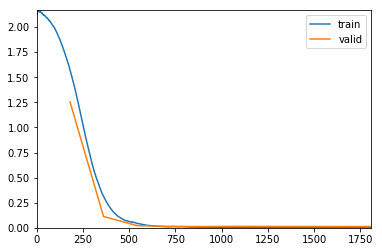

In [141]:
model = experiment(df)

In [142]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.01243656501173973: accuracy: 99.72%


In [143]:
def drawConfusionMatrix(model):
    preds, y, losses = model.get_preds(with_loss=True)
    interp = ClassificationInterpretation(model, preds, y, losses)
    interp.plot_confusion_matrix()

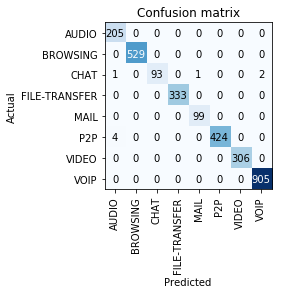

In [144]:
drawConfusionMatrix(model)